In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [2]:
# -----------------------------
# add "src" as import path
path = os.path.join('/home/tsuyoshi/local_transformation_model/src/src_rev_bilinear/')
sys.path.append(path)
path = os.path.join('/home/tsuyoshi/local_transformation_model/src/')
sys.path.append(path)

In [3]:
#import models.convolution_lstm_mod
import rev_bilinear
from rev_bilinear_interp import RevBilinear

In [4]:
sys.path

['/home/tsuyoshi/local_transformation_model/notebook',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python37.zip',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/lib-dynload',
 '',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/pretrainedmodels-0.7.4-py3.7.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/munch-2.5.1.dev12-py3.7.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/grid_average-0.0.0-py3.7-linux-x86_64.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/rev_trilinear-0.0.0-py3.7-linux-x86_64.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/rev_bilinear-0.0.0-py3.7-linux-x86_64.egg',
 '/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions',
 '/home/tsuyoshi/.ipython',
 '/home/tsuyoshi/local

Prepare Model

In [5]:
from models.euler_lagrange_predictor import Euler_Lagrange_Predictor

In [6]:
kernel_size = 3
image_size = 128
batch_size = 1
hidden_channels = 8
model = Euler_Lagrange_Predictor(input_channels=1, hidden_channels=hidden_channels,
                                 kernel_size=kernel_size,image_size=image_size,batch_size=batch_size,mode="check").cuda()
#model = Euler_Lagrange_Predictor(input_channels=1, hidden_channels=hidden_channels,
#                                 kernel_size=kernel_size,image_size=image_size,batch_size=batch_size).cuda()

Prepare Simple Data to check the functionality of the model

In [7]:
# define size
height = image_size
width = image_size
# define position of circle
ic = 50
jc = 50
# spatial scale
scale = 25
# time steps
tsize = 12

In [8]:
# create initial field
R = torch.zeros(1,tsize,1,height,width).cuda()
# create xy grid
xx = torch.arange(0, width).view(1, -1).repeat(height, 1).float()
yy = torch.arange(0, height).view(-1, 1).repeat(1, width).float()
# create circular field
for n in range(tsize):
    R[0,n,0,:,:] = torch.exp(-((xx-ic)**2 + (yy-jc)**2)/scale**2)

In [9]:
R.shape

torch.Size([1, 12, 1, 128, 128])

In [10]:
# plot a 2-d field
def plot_field(X,title,vmin=0,vmax=1):
    plt.imshow(X,vmin=vmin,vmax=vmax,cmap="GnBu",origin='lower')
    plt.colorbar()
    plt.grid()
    plt.title(title)
    plt.show()

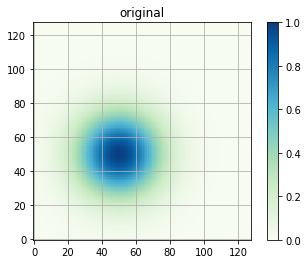

In [11]:
# plot on a grid
plot_field(R[0,-1,0,:,:].detach().cpu().numpy(),"original")

Apply the function

In [12]:
#output = model(R)
xout,uvout,r_pc_out,xy_pc_out = model(R)

/home/tsuyoshi/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [13]:
xy_pc_out.shape,r_pc_out.shape

(torch.Size([1, 12, 2, 16384]), torch.Size([1, 12, 1, 16384]))

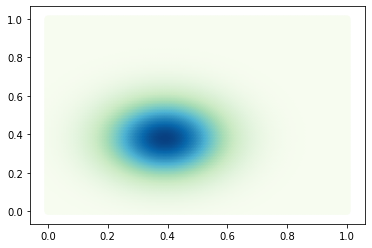

In [14]:
# test plot
x = xy_pc_out[0,-1,0,:].detach().cpu().numpy()
y = xy_pc_out[0,-1,1,:].detach().cpu().numpy()
value = r_pc_out[0,-1,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu")

In [15]:
x

array([0.        , 0.00787402, 0.01574803, ..., 0.984252  , 0.992126  ,
       1.        ], dtype=float32)

In [16]:
torch.max(xout)

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)

In [17]:
xout.shape

torch.Size([1, 12, 1, 128, 128])

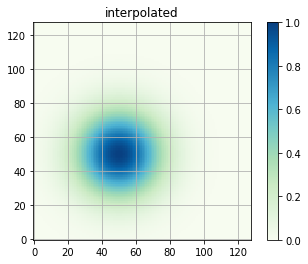

In [18]:
# plot on a grid
plot_field(xout[0,-1,0,:,:].detach().cpu().numpy(),"interpolated")

In [50]:
torch.max(Rgrd)

tensor(0.9585, device='cuda:0', grad_fn=<MaxBackward1>)

In [51]:
torch.min(Rgrd)

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

Convert from grid to point

In [70]:
input = Rgrd
vgrid = XY_scl.permute(0, 2, 1).reshape(1, 40, 40, 2)
# scale grid to [-1,1]
vgrid = (vgrid - 0.5) * 2.0
output = torch.nn.functional.grid_sample(input, vgrid)

In [71]:
XY_scl.shape

torch.Size([1, 2, 1600])

In [72]:
torch.min(XY_scl)

tensor(0.0002, device='cuda:0', grad_fn=<MinBackward1>)

In [73]:
output_pc = output.reshape(1, 1, 1600)

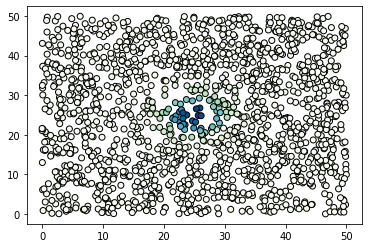

In [74]:
# plot on a grid
value = output_pc[0,0,:].detach().cpu().numpy()
plt.scatter(x, y, c=value, cmap="GnBu", edgecolors="black")